<a href="https://colab.research.google.com/github/MollyQI3104/computer_vision/blob/master/%E2%80%9CDataAug_Mixup_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torchvision.datasets.vision as vision
import warnings
from PIL import Image
import os
import os.path
import torch.nn as nn
import random
import numpy as np
import torch
import codecs
from torchvision.datasets.utils import download_url, download_and_extract_archive, extract_archive, \
    makedir_exist_ok, verify_str_arg


class MyMNIST(vision.VisionDataset):

    def ChooseSamples(self, images, targets, limit_data_num):
        chosen_samp_ids = random.sample(set(np.arange(0, len(targets), 1)), limit_data_num)
        random.shuffle(chosen_samp_ids)
        lim_images  = []
        lim_targets = []
        for chosen_id in chosen_samp_ids:
            lim_images.append(images[chosen_id, :,:])
            lim_targets.append(targets[chosen_id])
        return lim_images, lim_targets 

    def __init__(self, root, train=True, 
                 transform=None, 
                 target_transform=None,
                 download=True, 
                 use_mixup=True,
                 limit_data_num = 1000):  

        super(MyMNIST, self).__init__(root)   
        self.train = train  

        # -------このブロックは見なくても大丈夫-------
        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file
        # -----------------------------------------

        self.use_mixup = use_mixup
        self.transform = transform
        # すべてのデータはここでloadされています。
        # self.imagesは訓練集（或いはテスト集）の画像です
        # self.targetsはラベルです。
        # self.imagesとself.targets のデータタイプは torch.Tensor, 
        # self.images の形は　[枚数, H, W]
        # self.targetsの形は　[枚数]
        # self.imagesとself.targetsはサンプルの順番が対応しています
        self.images, self.targets = torch.load(os.path.join(self.processed_folder, data_file))

        # 一部のデータを制限する場合。
        if not limit_data_num is None:
            self.chosen_images, self.chosen_targets = self.ChooseSamples(self.images, self.targets, limit_data_num)
        else:
            self.chosen_images, self.chosen_targets = self.images, self.targets
        

    def __getitem__(self, index):
        img, target = self.chosen_images[index], int(self.chosen_targets[index])

        # transformに合うために下のを実行します。
        img = Image.fromarray(img.numpy(), mode='L')

        if self.use_mixup:
           # Randomly choose an image to mixup with.
            mixup_id  = random.choice(np.arange(0, len(self.chosen_targets), 1))
            mixup_img = self.chosen_images[mixup_id]
            mixup_img = Image.fromarray(mixup_img.numpy().copy(), mode='L')

            # Make target
            target = np.asarray([target, int(self.chosen_targets[mixup_id])])
            
        # Transform img.
        if not self.transform is None:
            img = self.transform(img)
            if self.use_mixup:
                mixup_img = self.transform(mixup_img)
                

        if self.use_mixup: 
            return img, mixup_img, target
        else:
            return img, target

    def __len__(self):
        return len(self.chosen_targets)





#ーーーーーーー下は見なくても大丈夫の内容ーーーーーーーーー
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.

    Args:
        root (string): Root directory of dataset where ``MNIST/processed/training.pt``
            and  ``MNIST/processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four',
               '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data

    @property
    def raw_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'raw')

    @property
    def processed_folder(self):
        return os.path.join(self.root, self.__class__.__name__, 'processed')

    @property
    def class_to_idx(self):
        return {_class: i for i, _class in enumerate(self.classes)}

    def _check_exists(self):
        return (os.path.exists(os.path.join(self.processed_folder,
                                            self.training_file)) and
                os.path.exists(os.path.join(self.processed_folder,
                                            self.test_file)))
        
    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""

        if self._check_exists():
            return

        makedir_exist_ok(self.raw_folder)
        makedir_exist_ok(self.processed_folder)

        # download files
        for url in self.urls:
            filename = url.rpartition('/')[2]
            download_and_extract_archive(url, download_root=self.raw_folder, filename=filename)

        # process and save as torch files
        print('Processing...')

        training_set = (
            read_image_file(os.path.join(self.raw_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.raw_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.raw_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def extra_repr(self):
        return "Split: {}".format("Train" if self.train is True else "Test")

def read_label_file(path):
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 1)
    return x.long()


def read_image_file(path):
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 3)
    return x

def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)


def open_maybe_compressed_file(path):
    """Return a file object that possibly decompresses 'path' on the fly.
       Decompression occurs when argument `path` is a string and ends with '.gz' or '.xz'.
    """
    if not isinstance(path, torch._six.string_classes):
        return path
    if path.endswith('.gz'):
        import gzip
        return gzip.open(path, 'rb')
    if path.endswith('.xz'):
        import lzma
        return lzma.open(path, 'rb')
    return open(path, 'rb')


def read_sn3_pascalvincent_tensor(path, strict=True):
    """Read a SN3 file in "Pascal Vincent" format (Lush file 'libidx/idx-io.lsh').
       Argument may be a filename, compressed filename, or file object.
    """
    # typemap
    if not hasattr(read_sn3_pascalvincent_tensor, 'typemap'):
        read_sn3_pascalvincent_tensor.typemap = {
            8: (torch.uint8, np.uint8, np.uint8),
            9: (torch.int8, np.int8, np.int8),
            11: (torch.int16, np.dtype('>i2'), 'i2'),
            12: (torch.int32, np.dtype('>i4'), 'i4'),
            13: (torch.float32, np.dtype('>f4'), 'f4'),
            14: (torch.float64, np.dtype('>f8'), 'f8')}
    # read
    with open_maybe_compressed_file(path) as f:
        data = f.read()
    # parse
    magic = get_int(data[0:4])
    nd = magic % 256
    ty = magic // 256
    assert nd >= 1 and nd <= 3
    assert ty >= 8 and ty <= 14
    m = read_sn3_pascalvincent_tensor.typemap[ty]
    s = [get_int(data[4 * (i + 1): 4 * (i + 2)]) for i in range(nd)]
    parsed = np.frombuffer(data, dtype=m[1], offset=(4 * (nd + 1)))
    assert parsed.shape[0] == np.prod(s) or not strict
    return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [0]:
class LeNet(nn.Module):
  def __init__(self, input_dim=1, num_class=10):
    super(LeNet, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(input_dim, 20,  kernel_size=5, stride=1, padding=0)
    self.conv2 = nn.Conv2d(    20,    50,  kernel_size=5, stride=1, padding=0)

    # Fully connected layers
    self.fc1 = nn.Linear(800, 500)
    self.fc2 = nn.Linear(500, num_class)
    
    # Activation func.
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.conv1(x))        # Conv.-> ReLU
    x = F.max_pool2d(x, kernel_size=2, stride=2)  # Pooling with 2x2 window
    x = self.relu(self.conv2(x))        # Conv.-> ReLU
    x = F.max_pool2d(x, kernel_size=2, stride=2)  # Pooling with 2x2 window

    b,c,h,w = x.size()                  # batch, channels, height, width
    x = x.view(b, -1)                   # flatten the tensor x

    x = self.relu(self.fc1(x))          # fc-> ReLU
    x = self.fc2(x)                     # fc
    return x

In [0]:
def train_step(imgs, labels_vec, model, loss_func):
    imgs = imgs.cuda()
    tars = labels_vec.cuda()
    preds = model(imgs)
    loss = loss_func(preds, tars)
    loss.backward()
    return preds, loss

In [0]:
from IPython.display import clear_output, display
import numpy as np
import time
def evaluate_model(net, testloader):
    net.eval()
    mnist_cls   = range(10)     #[0, 1, 2, 3, ..., 9]
    val_confmat = np.zeros((len(mnist_cls), len(mnist_cls))) # confusion matrix. [x_axis for groundtruth answers]; [y_axis for CNN's predictions].
    total_num   = 0
    correct_num = 0
    for test_iter, test_data in enumerate(testloader):

        # Get one batch of test samples
        inputs, labels = test_data    

        # Move inputs and labels into GPU
        inputs = inputs.cuda()
        labels = torch.LongTensor(list(labels)).cuda()

        # Forward
        outputs = net(inputs)   

        # Get predicted classes
        _, pred_cls = torch.max(outputs, 1)

        # Record test result
        bch = pred_cls.size(0)
        correct_num+= (pred_cls == labels).float().sum().item()
        total_num+= bch
        for b in range(bch):
            val_confmat[pred_cls[b], labels[b]]+= 1
    net.train()
    confmat_rec.append([correct_num/float(total_num), val_confmat.copy()])

    # Print accuracy and show confusion matrecs. 
    print("Accuracy: "+"%.2f"%(correct_num/float(total_num)))
    plt.clf()
    plt.imshow(val_confmat, interpolation='nearest',cmap=plt.cm.bone)
    plt.yticks(np.arange(len(mnist_cls)))
    plt.xticks(np.arange(len(mnist_cls)))
    plt.ylabel("CNN's prediction")
    plt.xlabel("Groudtruth")
    plt.title("Confusion matrix for classification on MNIST")
    plt.show()
    time.sleep(3)
    # return val_confmat, correct_num


Epoch [71/100], Iteration: 50, Loss: 0.3963219504803419.


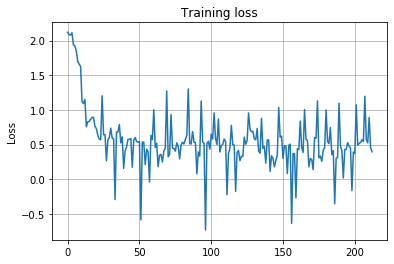

In [0]:
# With mixup
# Limited sample number = 500
# mixup_weight: 
#  - w1 = randomly chosen from [0.7, 1]
#  - w2 = 1 - w1
# ポイント：　mixup_weightの範囲を調整。
weight_range = [0.7, 1]

import torchvision.transforms as transforms
import torch.utils as utils
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets as datasets

def CrossEntropy(preds, labels):
    preds = F.softmax(preds, dim=1)
    N = labels.shape[0]
    cross_entropy = -torch.sum(labels*torch.log(preds+1e-12)) / N
    return cross_entropy


def GetMixupWeights(weight_range, step):
    minV, maxV = weight_range
    w1 = random.choice(np.arange(minV, maxV+step, step))
    w2 = maxV - w1
    return [w1, w2]

def MixupSample(img1, img2, weights):
    w1, w2 = weights
    bch,c,h,w = img1.size()
    for b in range(bch):
        img1[b,:]*= w1
        img1[b,:]+= img2[b,:]*w2
    return img1


# Make a transform func.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
# Prepare dataloader
mnist_train = MyMNIST('./data', train=True,  download=True, transform=transform, use_mixup=True, limit_data_num=500)
trainloader = utils.data.DataLoader(mnist_train, batch_size=10, shuffle=True, num_workers=2)

mnist_test  = datasets.MNIST('./data', train=False, download=True, transform=transform)
testloader  = utils.data.DataLoader(mnist_test, batch_size=10, shuffle=False, num_workers=2)

# Make net
net = LeNet().cuda()
net.train()

# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epoch_size  = 100
loss_rec    = []
iter_rec    = []
confmat_rec = []
global confmat_rec

for epoch in range(epoch_size):
    running_loss = 0.0
    ct_num       = 0.0
    # Iterate the dataloader
    for iteration, data in enumerate(trainloader):
        # Get one batch
        img, mixup_img, targets = data

        # Get mixup weights for the batch
        mixup_weights = GetMixupWeights(weight_range=weight_range, step=0.1)

        # Mixup images
        img = MixupSample(img, mixup_img, mixup_weights)

        # Show the mixuped images.
        show_imgs = torchvision.utils.make_grid(img, nrow=10, normalize=True).numpy().transpose((1,2,0))
        plt.imshow(show_imgs)

        # Show the targets
        #print(targets)

        # label vectorを作成
        cls_num = 10
        bch,dim,h,w = img.size()
        labels_vec = torch.FloatTensor(bch, cls_num)
        for i, tar in enumerate(targets):
            vec = torch.zeros(10)
            vec[tar[0]] = mixup_weights[0]
            vec[tar[1]] = mixup_weights[1]
            labels_vec[i,:] = vec

        # Show the labels_vector.
        # print(labels_vec)

        # Forward+backward, then update params.
        optimizer.zero_grad()
        preds, loss = train_step(img, labels_vec, model=net, loss_func=CrossEntropy)
        optimizer.step()

        # Logging
        with torch.no_grad():
            running_loss+= loss.item()
            ct_num+= 1
        if iteration in [1, 39, 59] or iteration%50 == 49:
            clear_output(wait=True)
            print("Epoch ["+str(epoch+1)+"/"+str(epoch_size)+"], Iteration: "+str(iteration+1)+", Loss: "+str(running_loss/ct_num)+'.')
            loss_rec.append(running_loss/ct_num)
            iter_rec.append(ct_num) 
            plt.clf()
            plt.grid(linestyle='-')
            plt.plot(loss_rec)
            plt.title("Training loss")
            plt.ylabel("Loss")
            plt.show()

        # Test the model
        if iteration in [1, 39, 59] or iteration%50 == 49:
            evaluate_model(net=net, testloader=testloader)

            # Record confusion matrix
            confmat_rec[-1]+= [epoch+1, iteration+1]

    # Lower the learning rate
    if epoch in [20, 60]:
        for param_group in optimizer.param_groups:
            param_group['lr']*= 0.1  


# Show all the confusion matrecs
for confmat_info in confmat_rec:
  accuracy, confmat, epoch, iteration = confmat_info
  plt.clf()
  plt.imshow(confmat, interpolation='nearest', cmap=plt.cm.bone)
  plt.yticks(np.arange(10))
  plt.xticks(np.arange(10))
  plt.ylabel("CNN's prediction")
  plt.xlabel("Groudtruth")
  plt.title("[Epoch / iter: "+str(epoch)+" / "+str(iteration)+"], accuracy: "+"%.2f"%accuracy)
  plt.show()
        

Epoch [100/100], Iteration: 50, Loss: 0.008442033724859356.


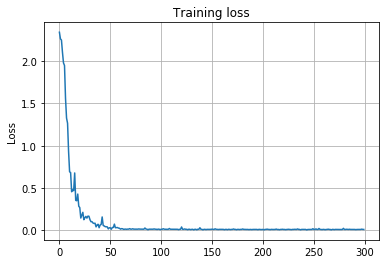

Accuracy: 0.90


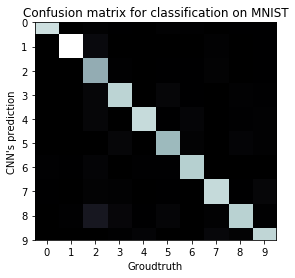

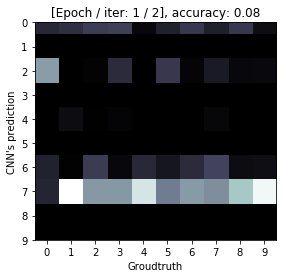

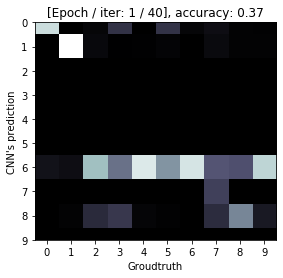

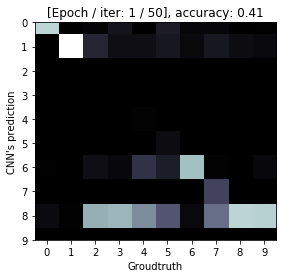

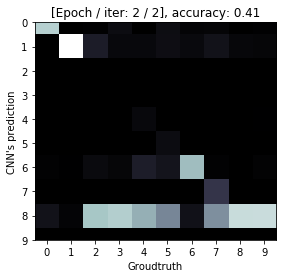

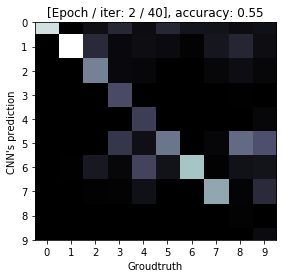

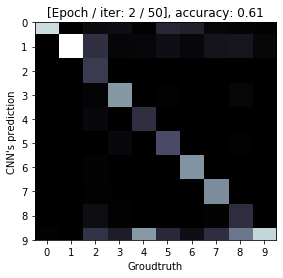

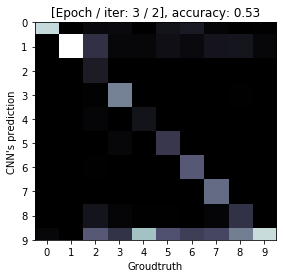

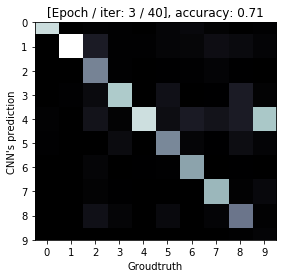

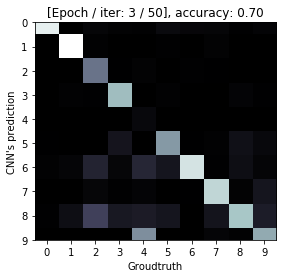

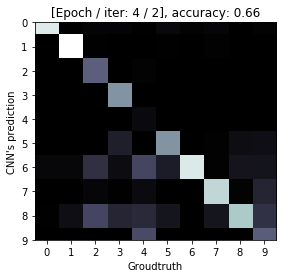

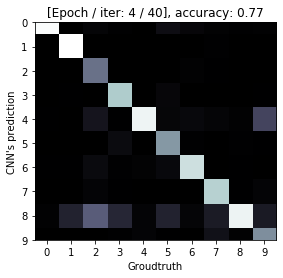

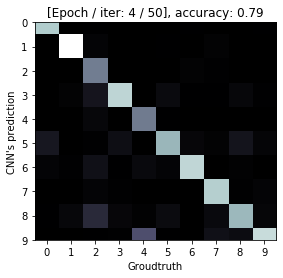

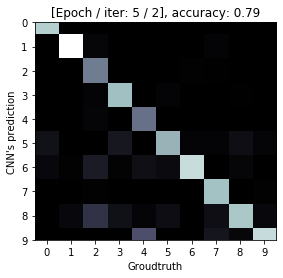

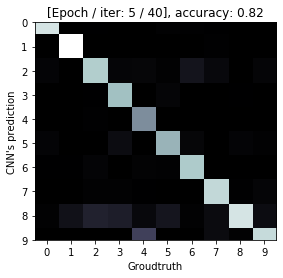

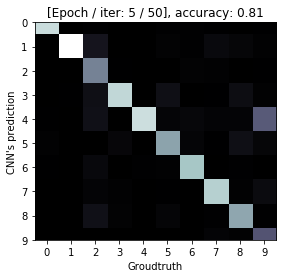

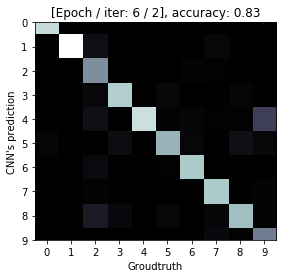

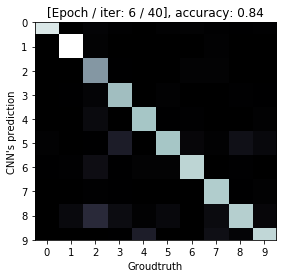

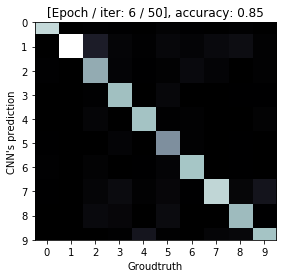

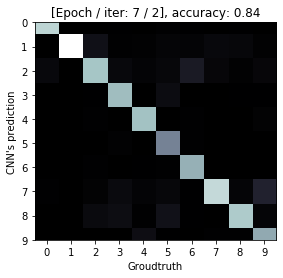

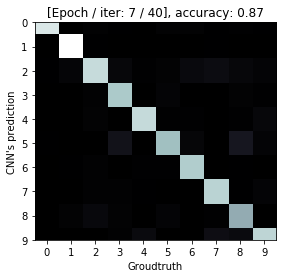

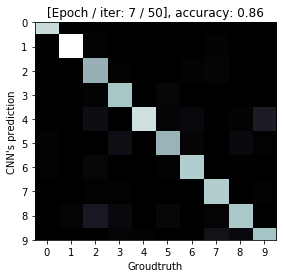

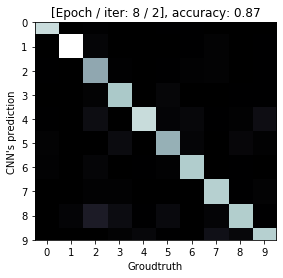

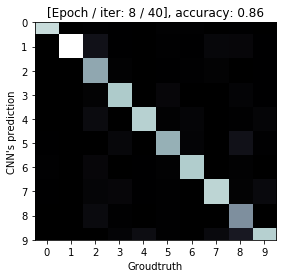

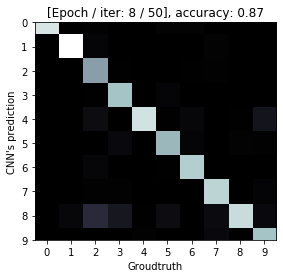

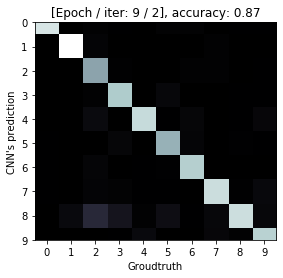

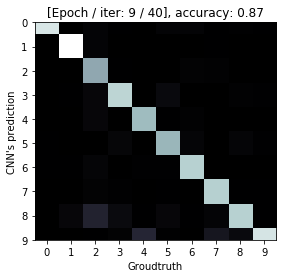

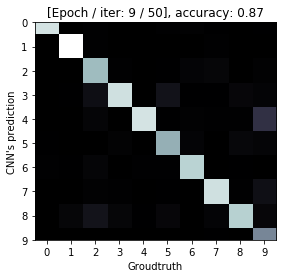

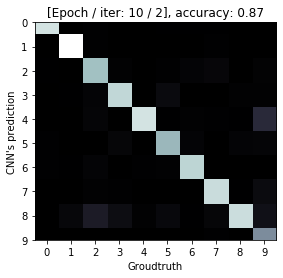

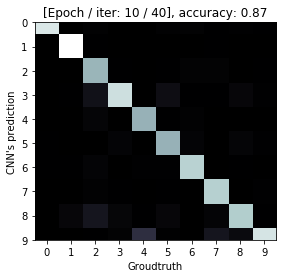

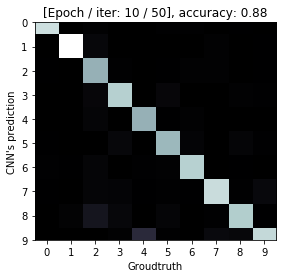

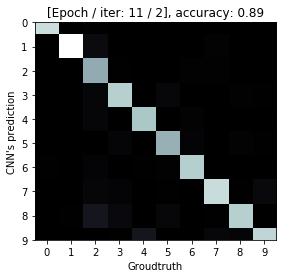

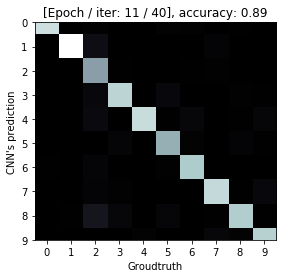

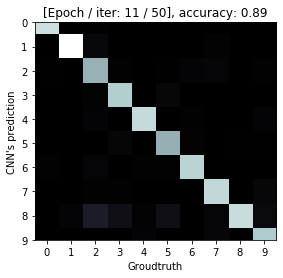

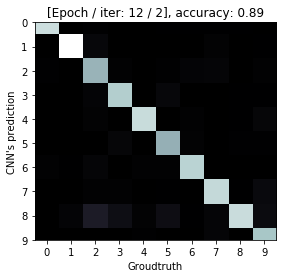

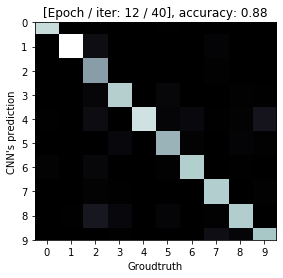

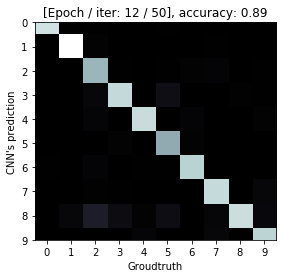

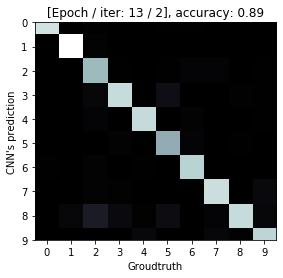

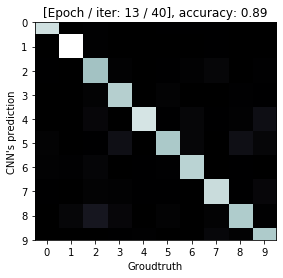

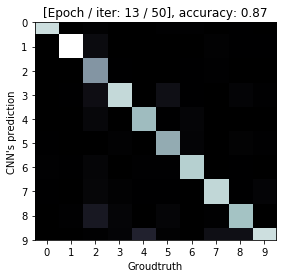

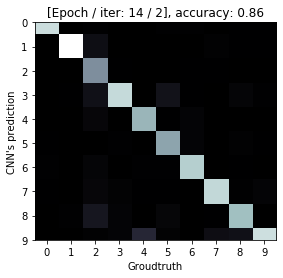

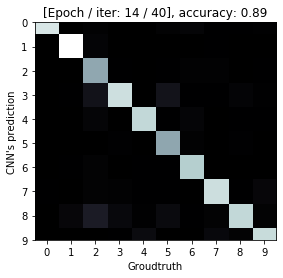

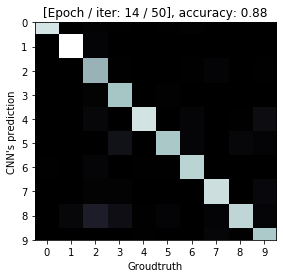

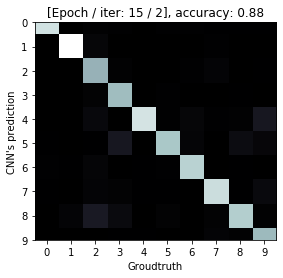

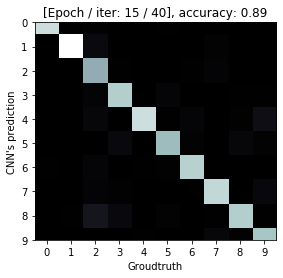

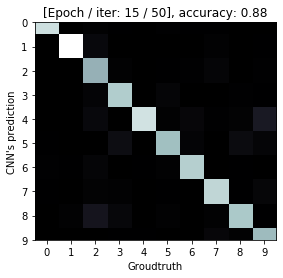

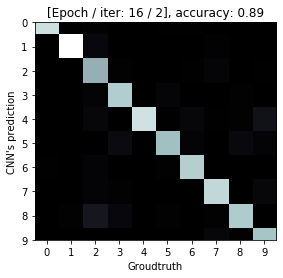

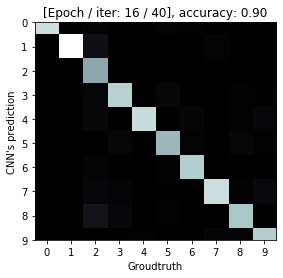

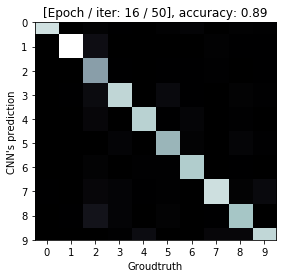

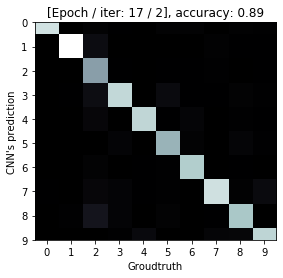

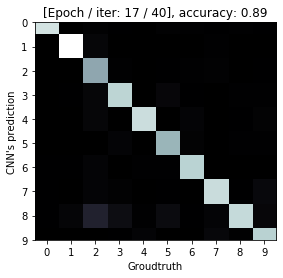

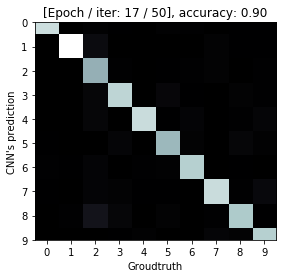

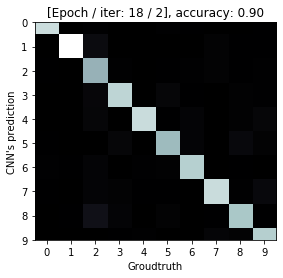

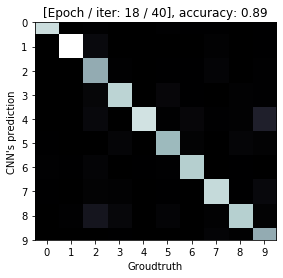

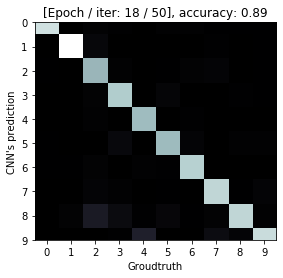

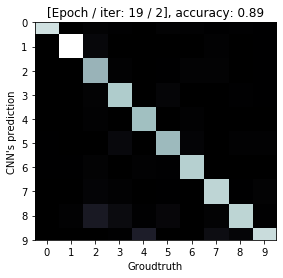

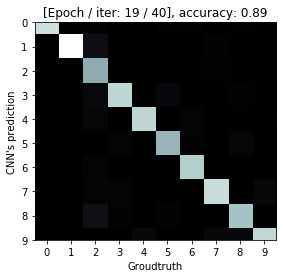

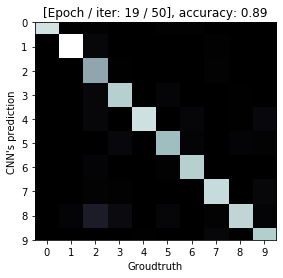

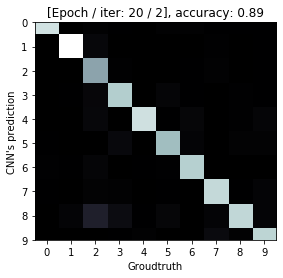

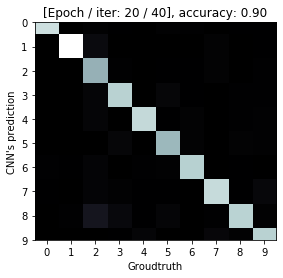

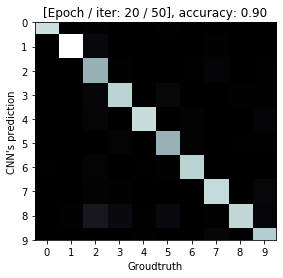

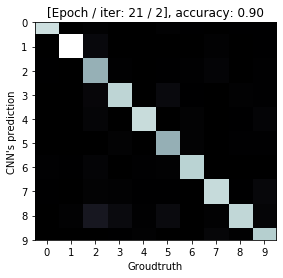

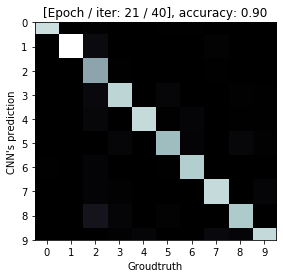

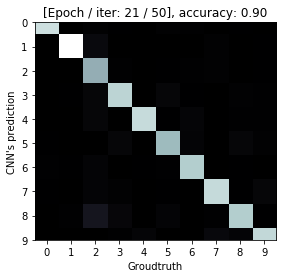

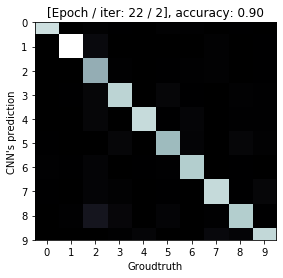

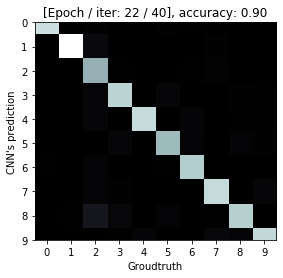

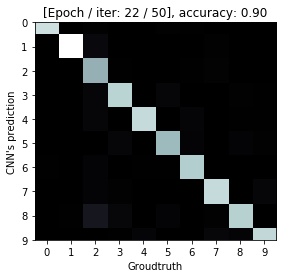

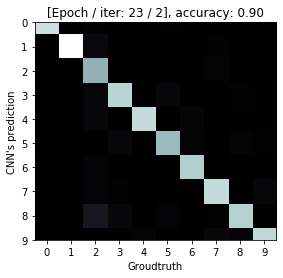

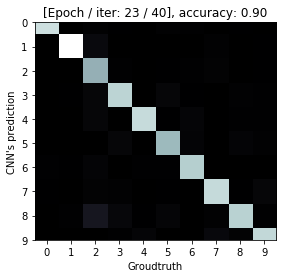

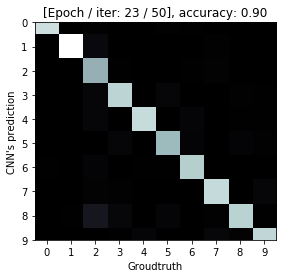

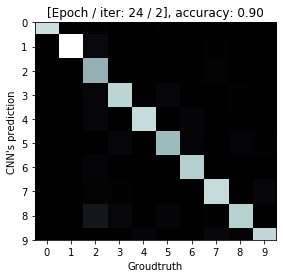

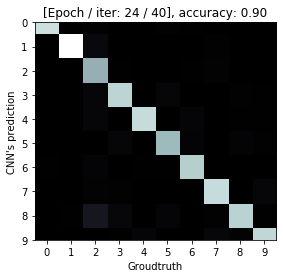

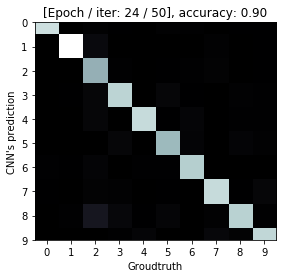

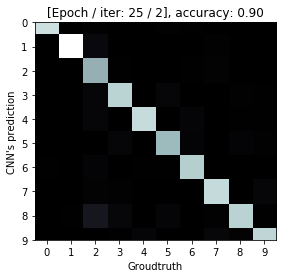

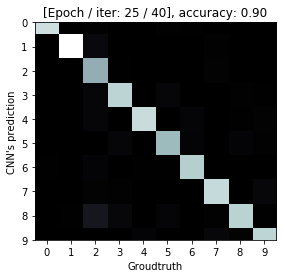

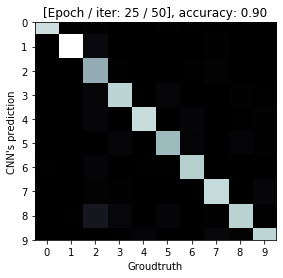

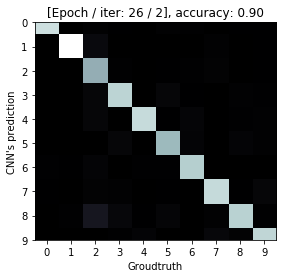

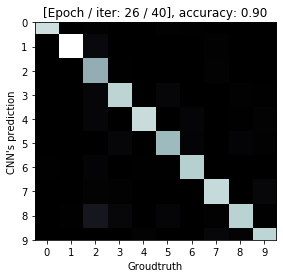

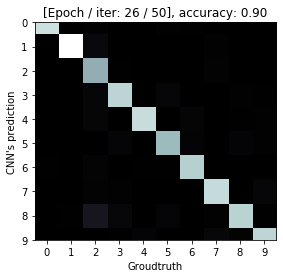

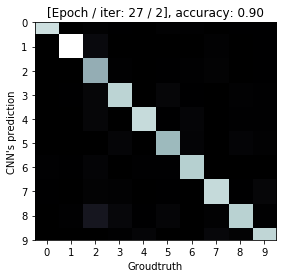

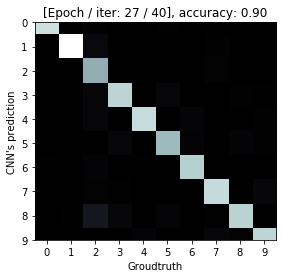

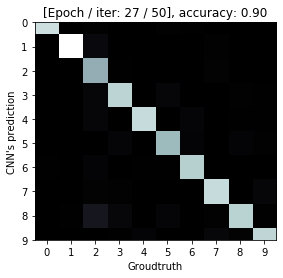

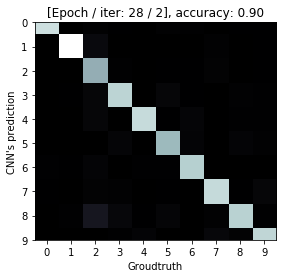

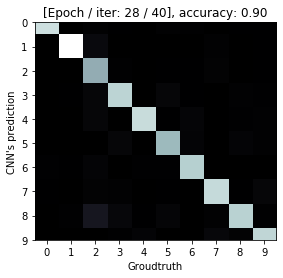

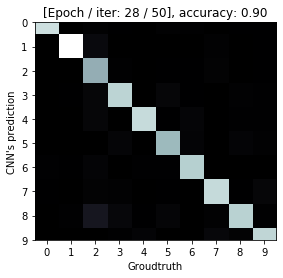

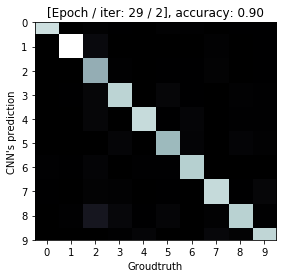

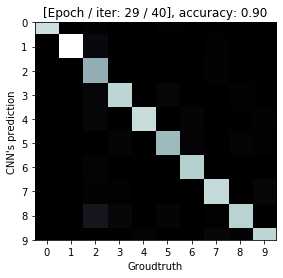

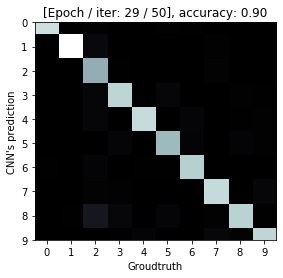

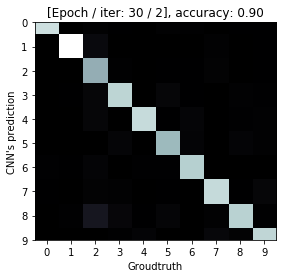

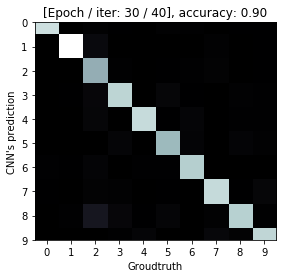

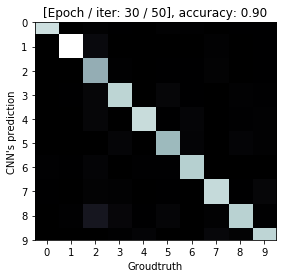

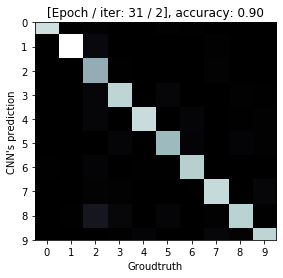

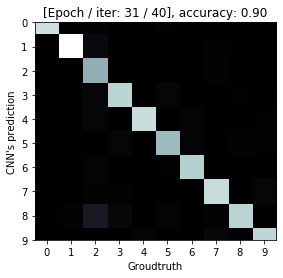

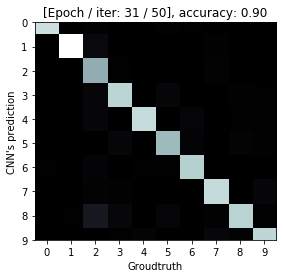

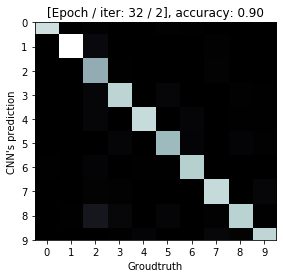

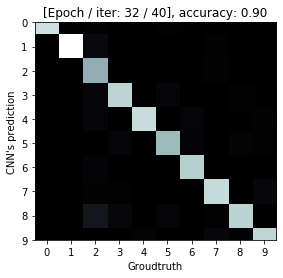

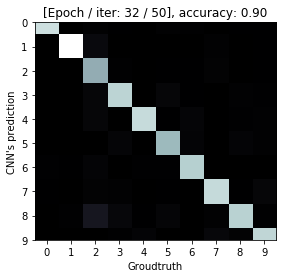

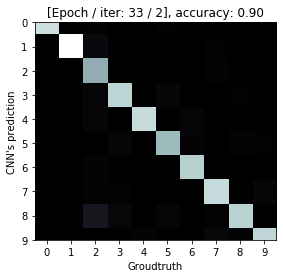

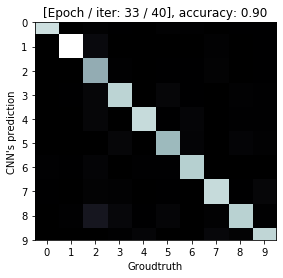

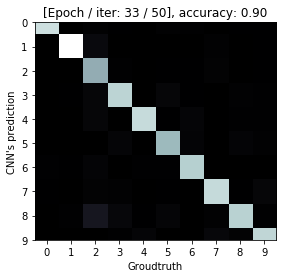

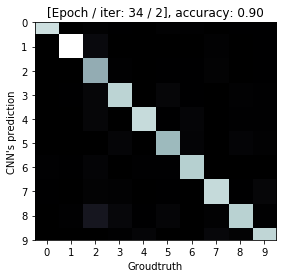

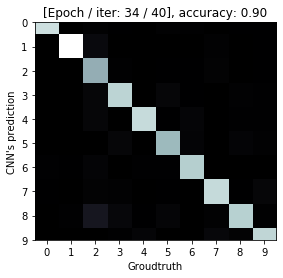

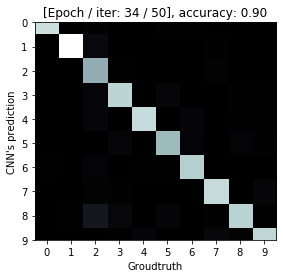

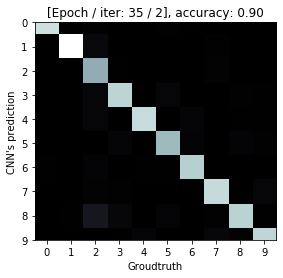

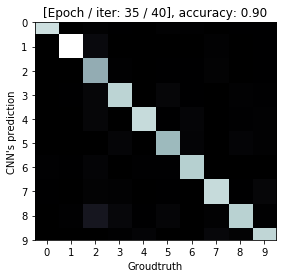

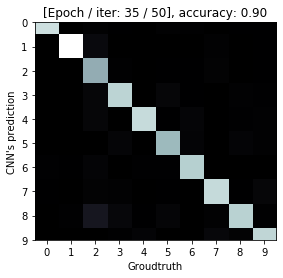

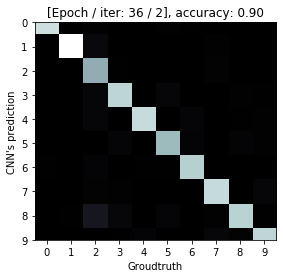

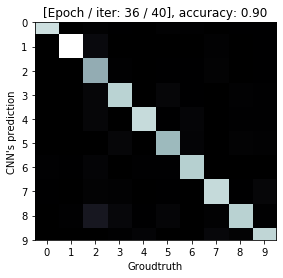

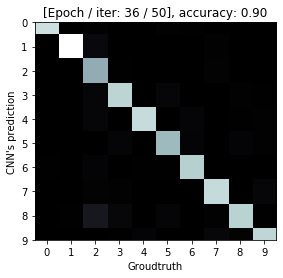

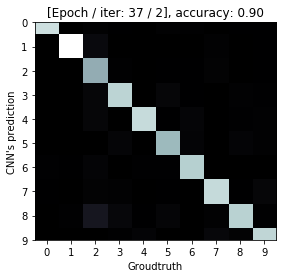

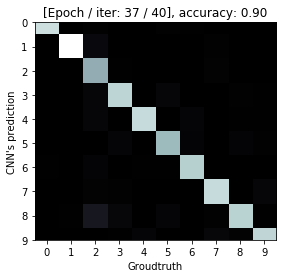

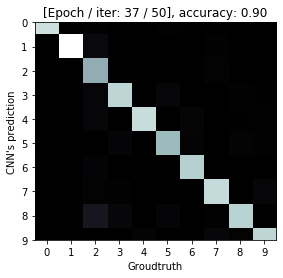

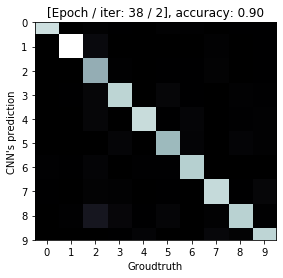

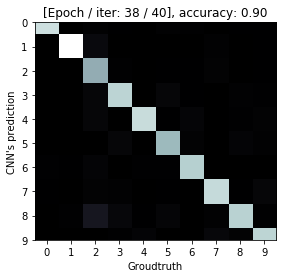

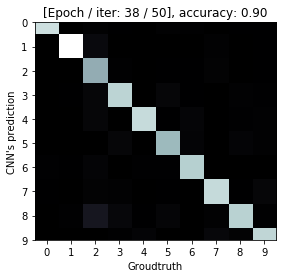

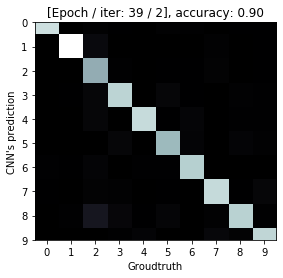

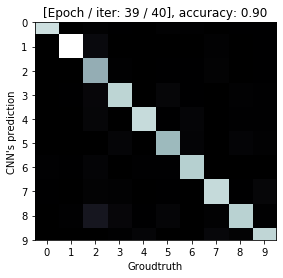

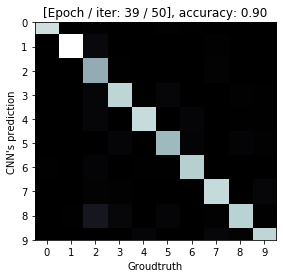

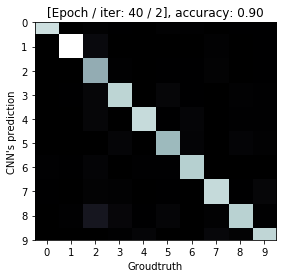

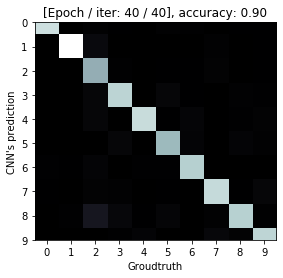

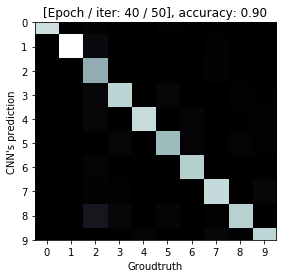

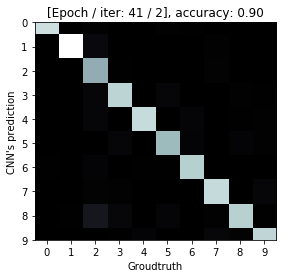

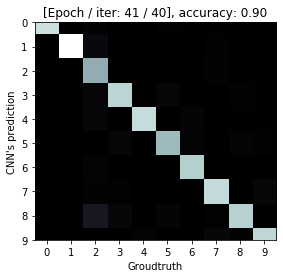

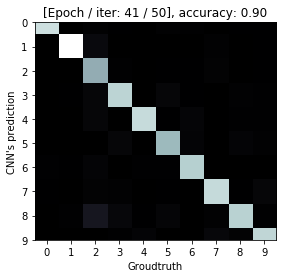

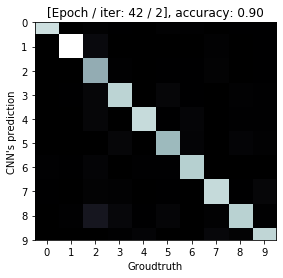

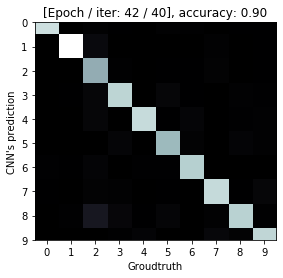

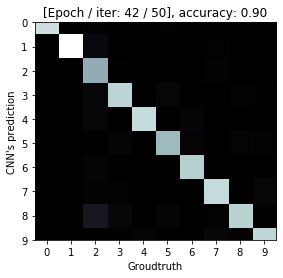

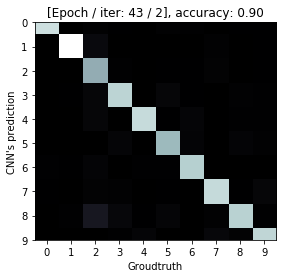

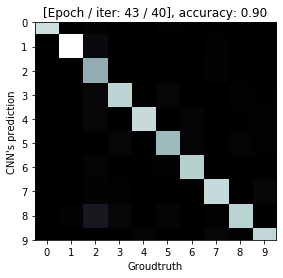

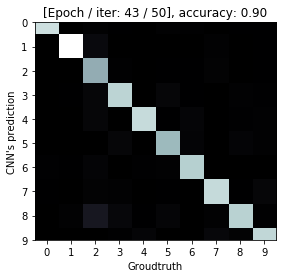

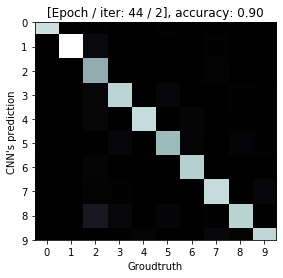

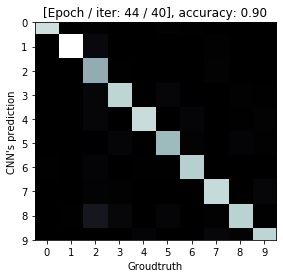

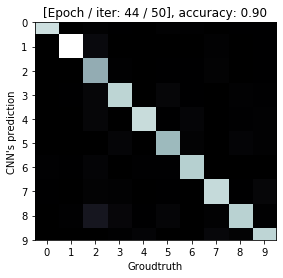

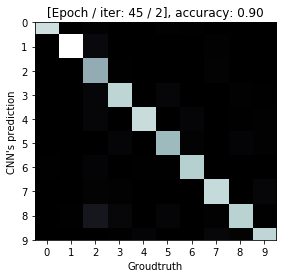

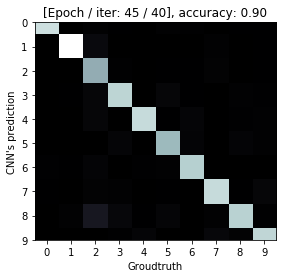

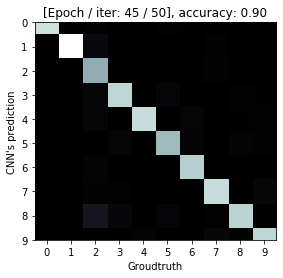

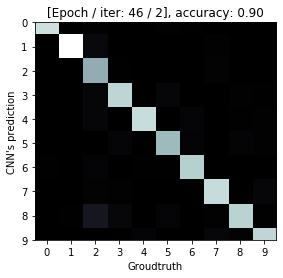

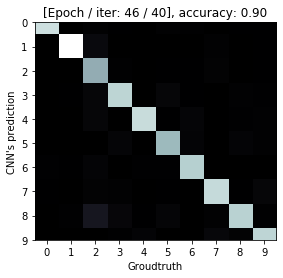

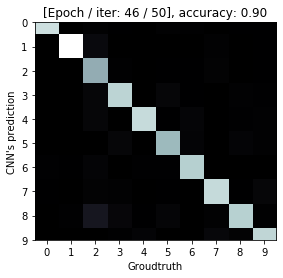

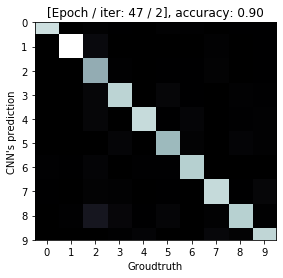

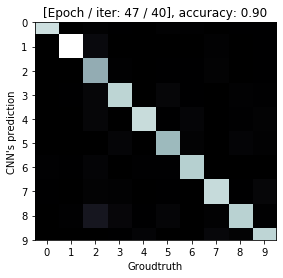

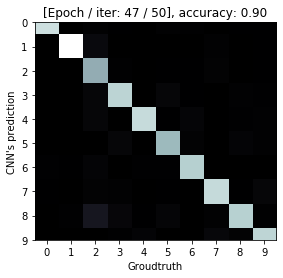

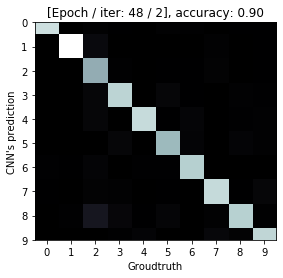

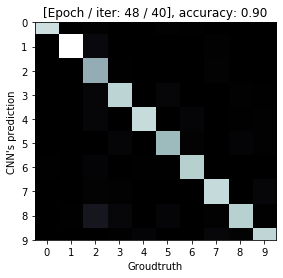

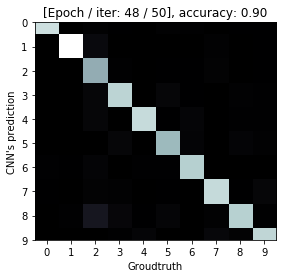

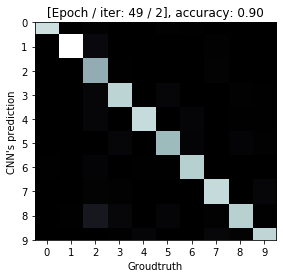

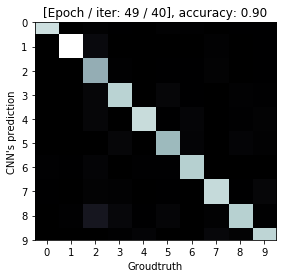

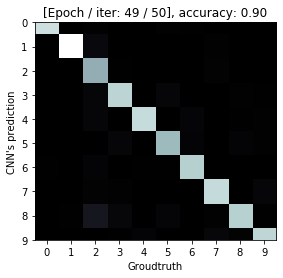

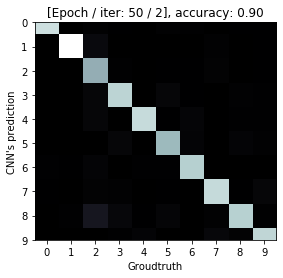

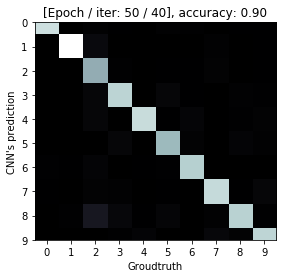

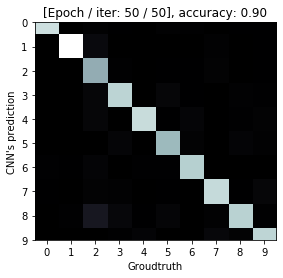

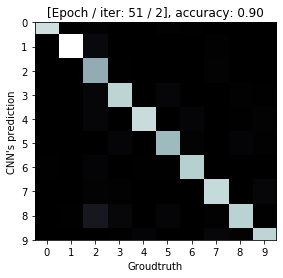

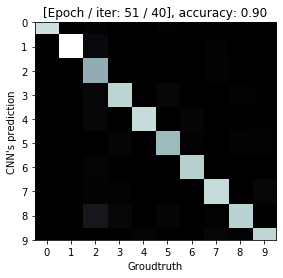

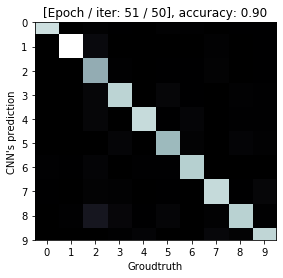

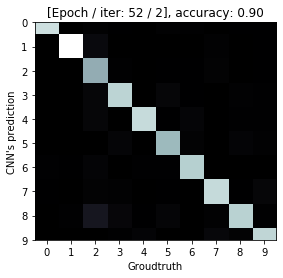

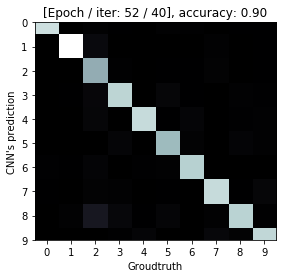

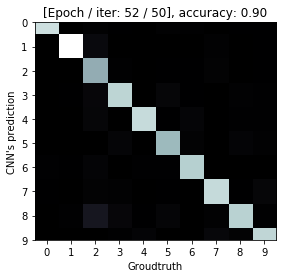

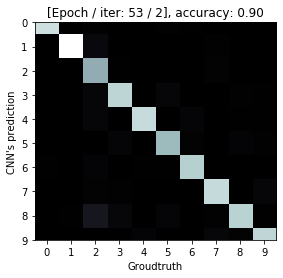

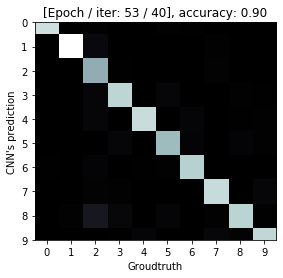

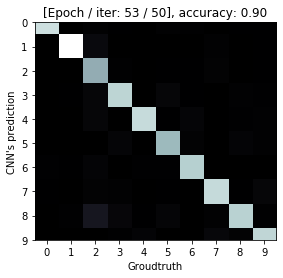

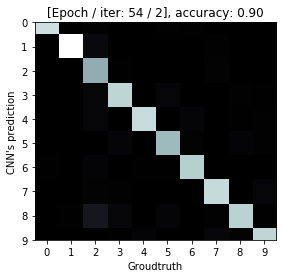

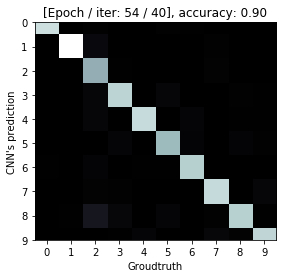

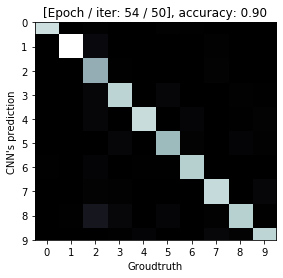

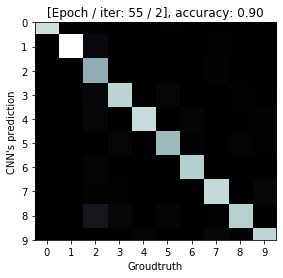

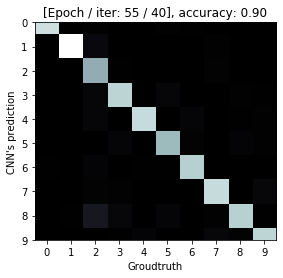

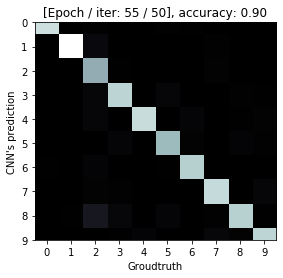

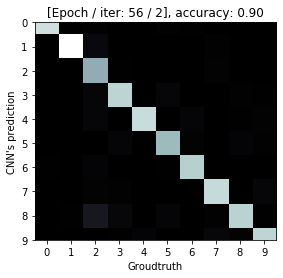

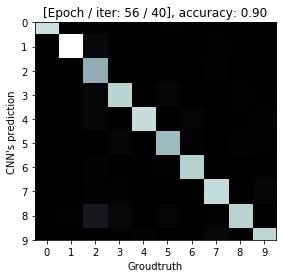

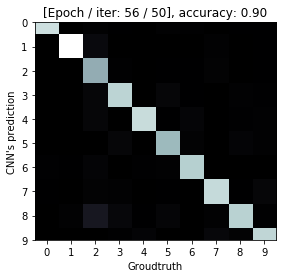

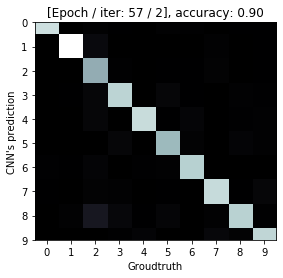

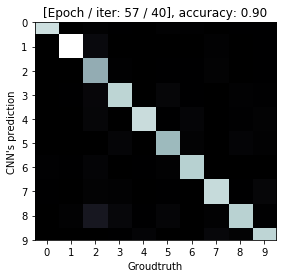

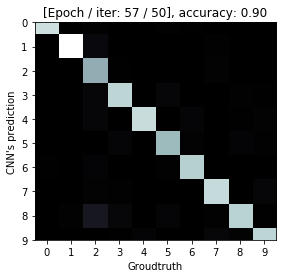

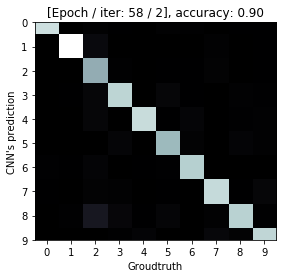

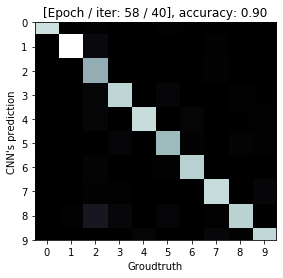

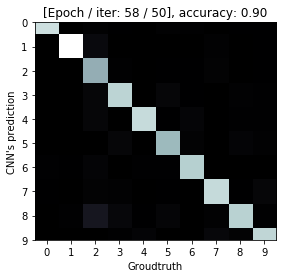

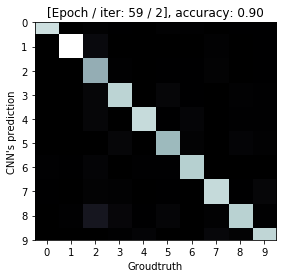

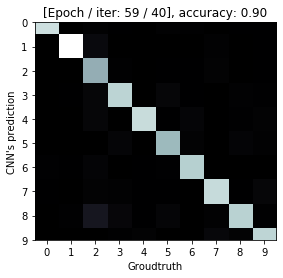

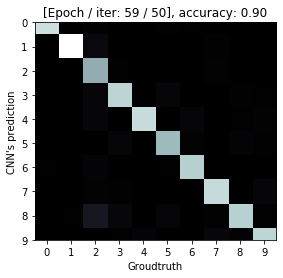

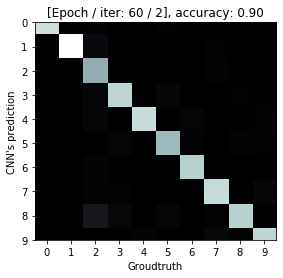

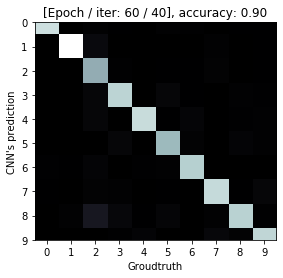

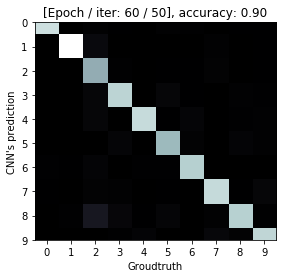

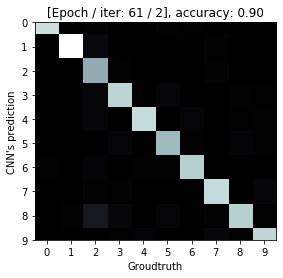

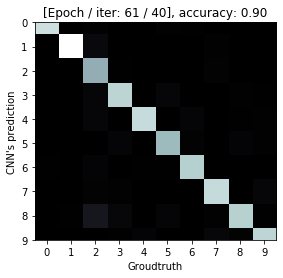

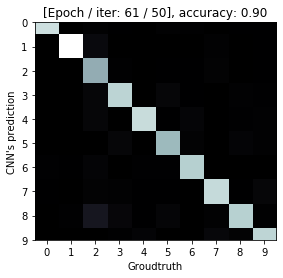

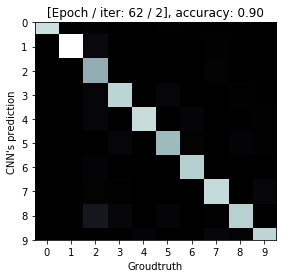

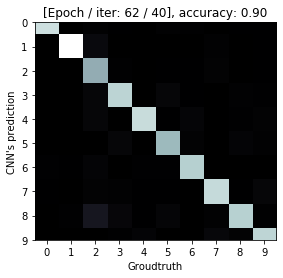

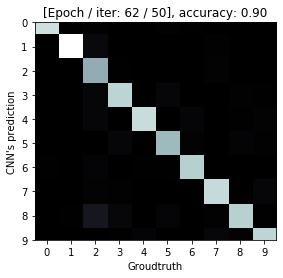

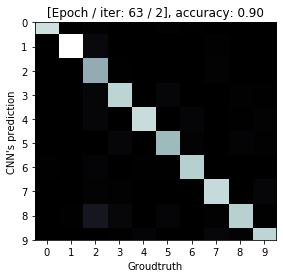

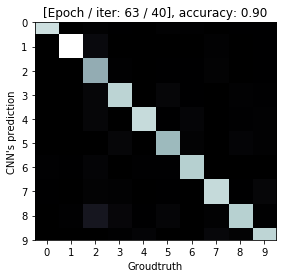

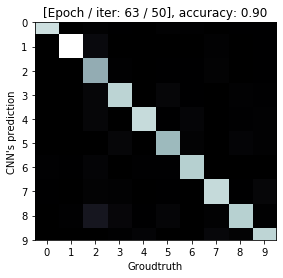

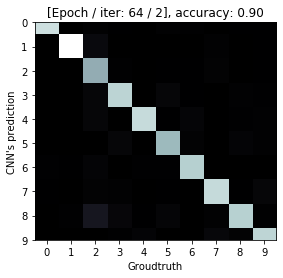

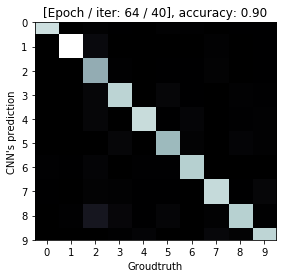

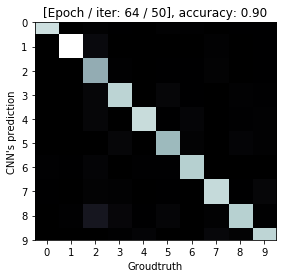

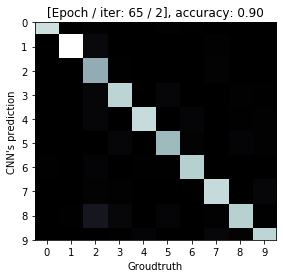

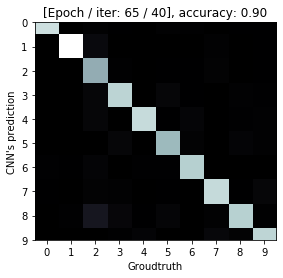

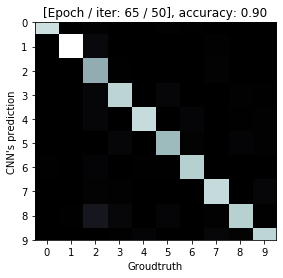

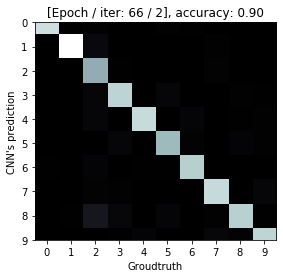

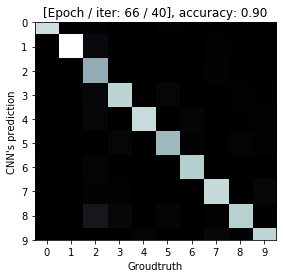

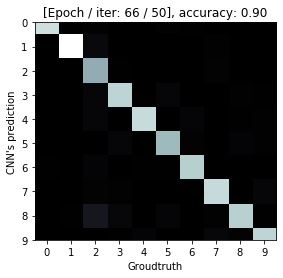

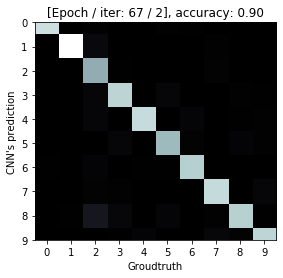

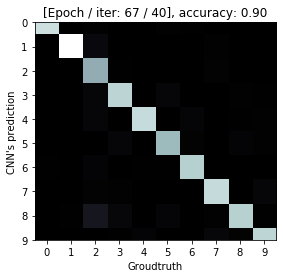

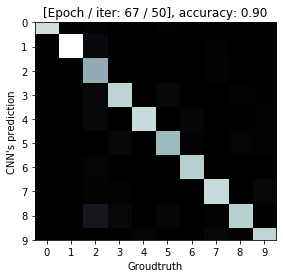

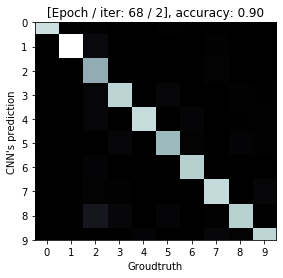

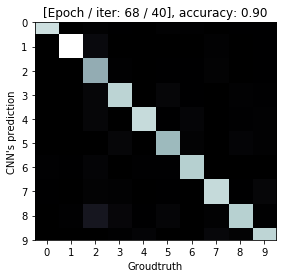

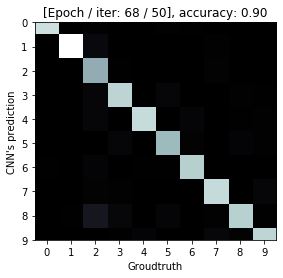

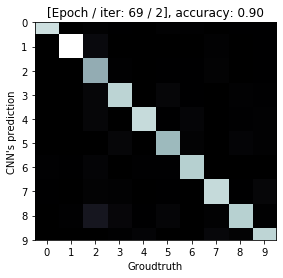

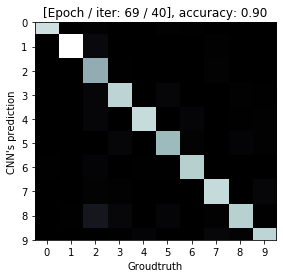

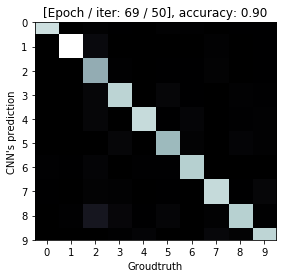

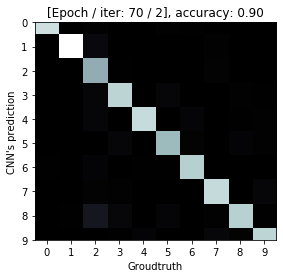

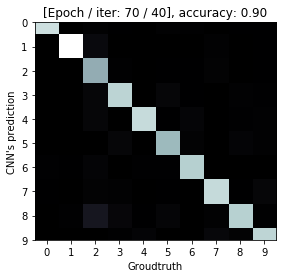

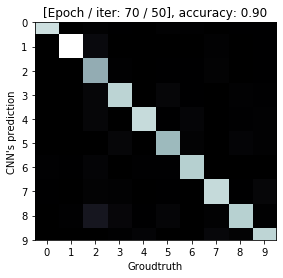

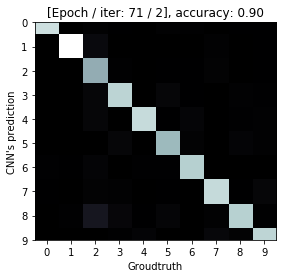

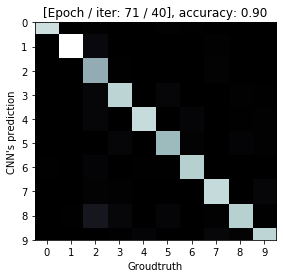

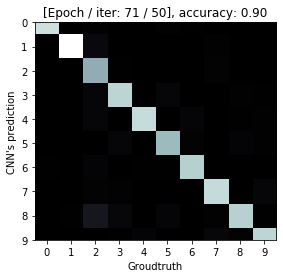

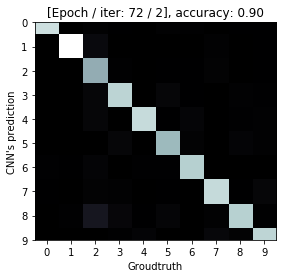

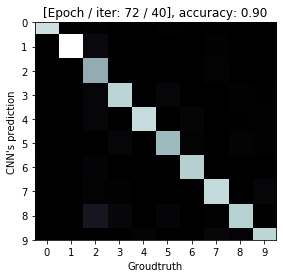

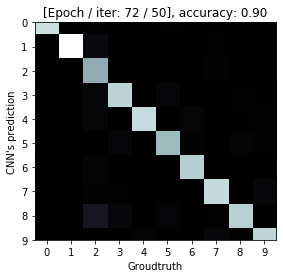

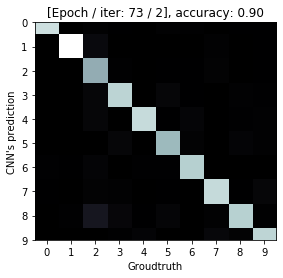

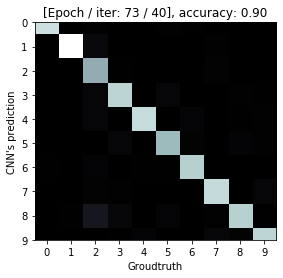

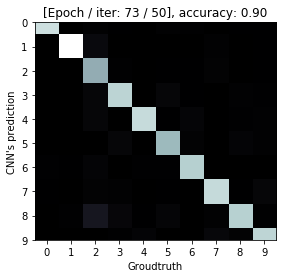

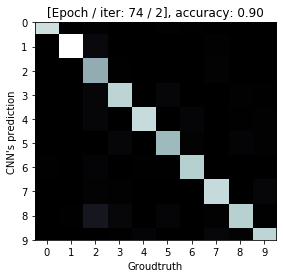

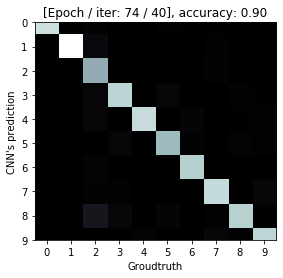

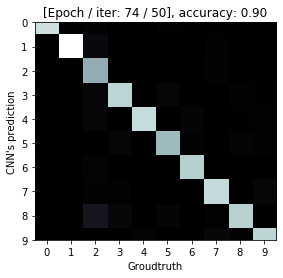

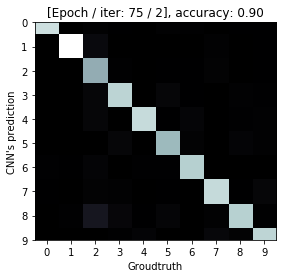

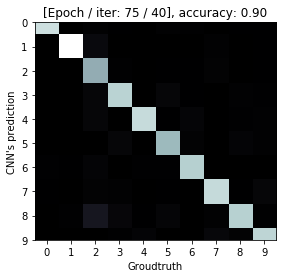

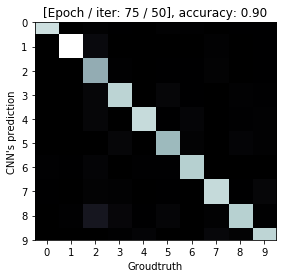

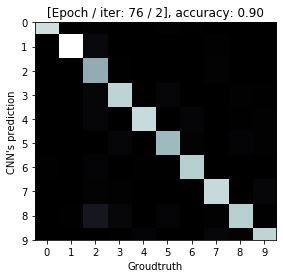

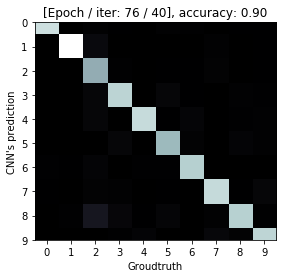

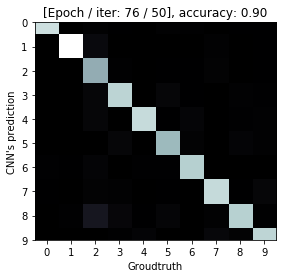

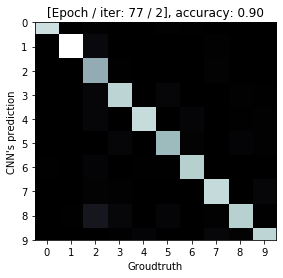

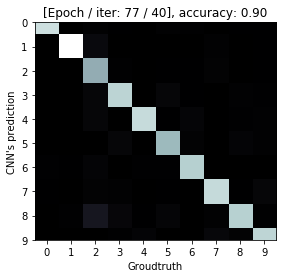

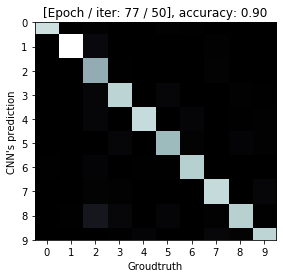

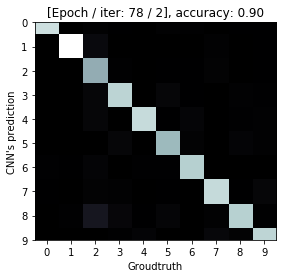

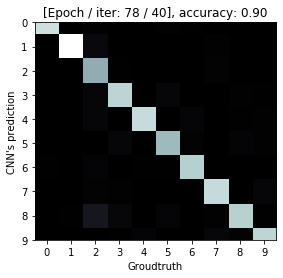

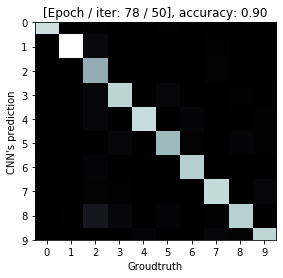

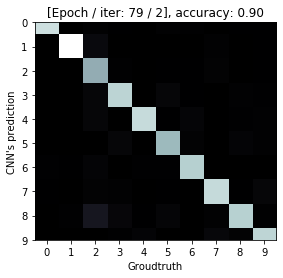

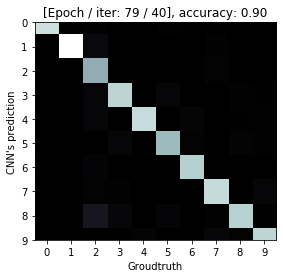

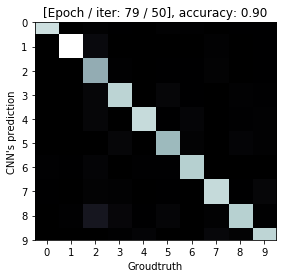

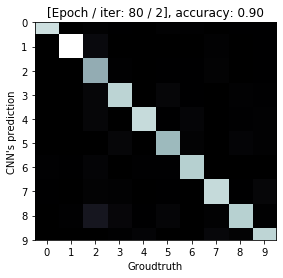

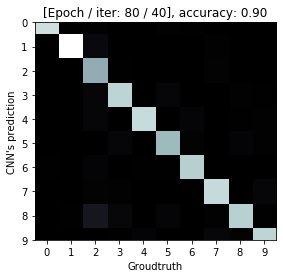

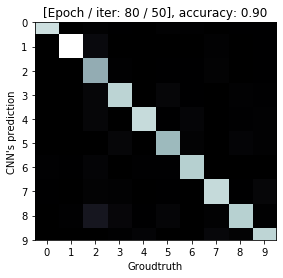

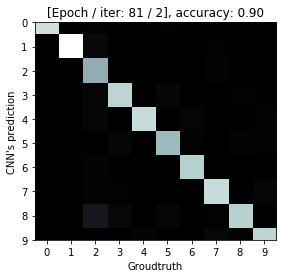

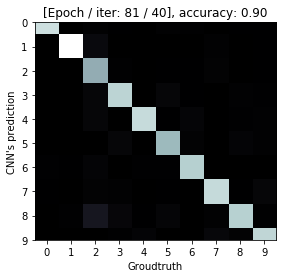

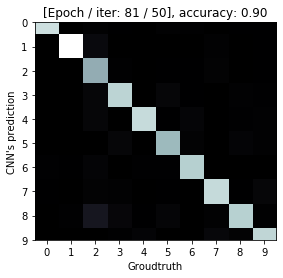

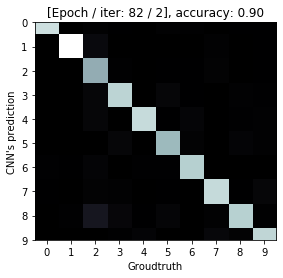

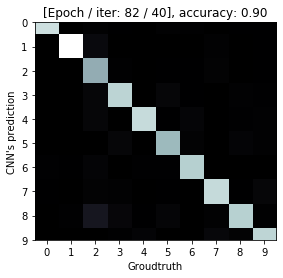

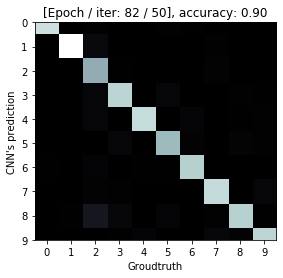

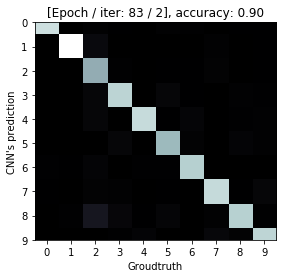

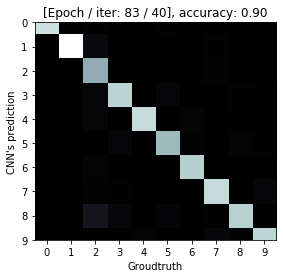

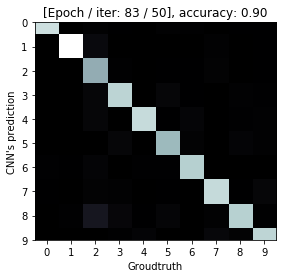

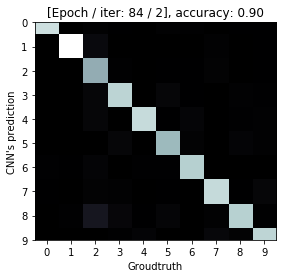

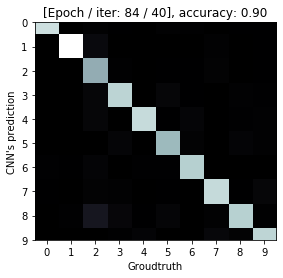

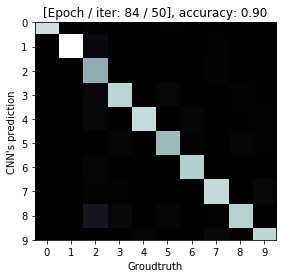

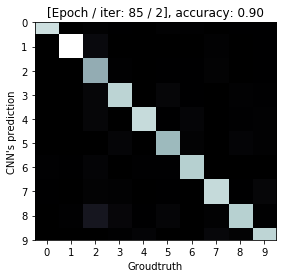

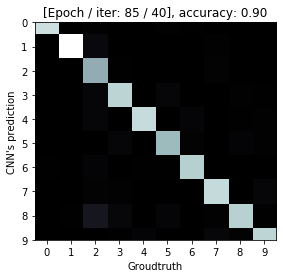

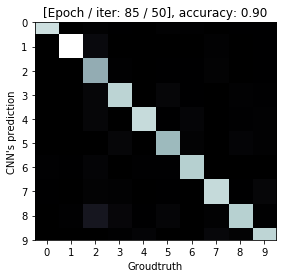

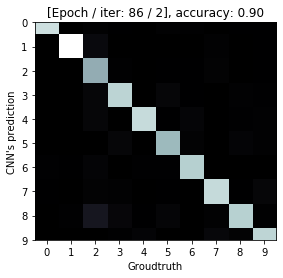

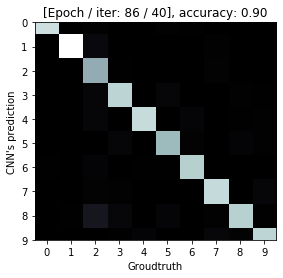

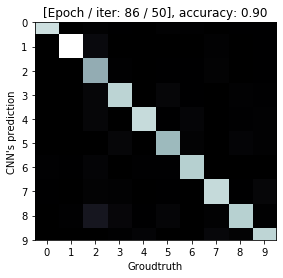

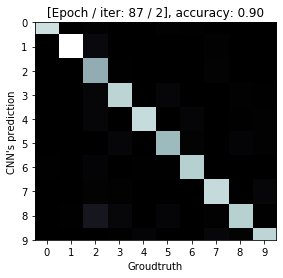

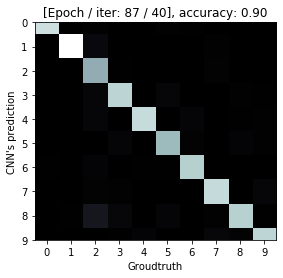

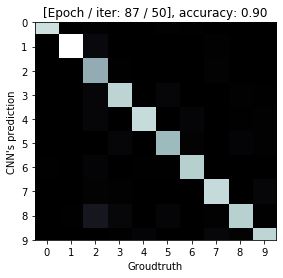

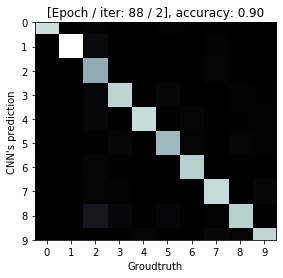

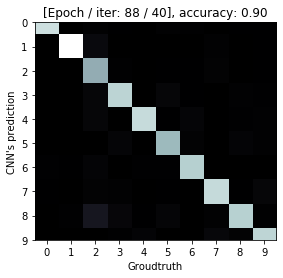

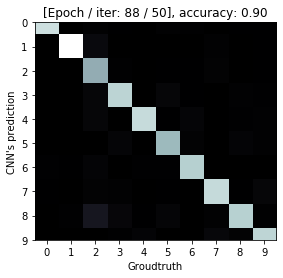

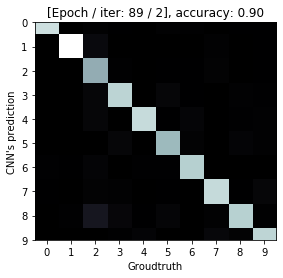

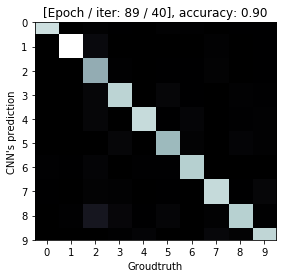

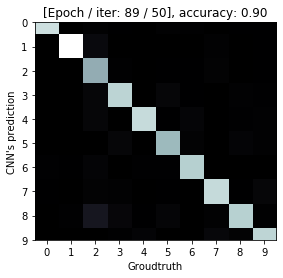

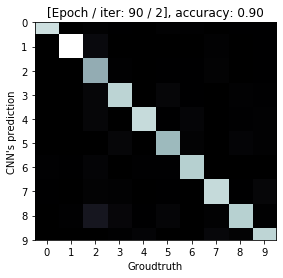

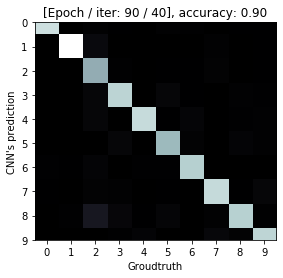

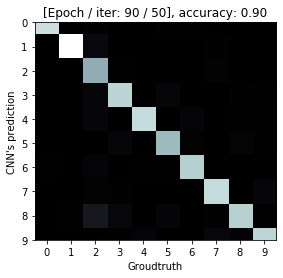

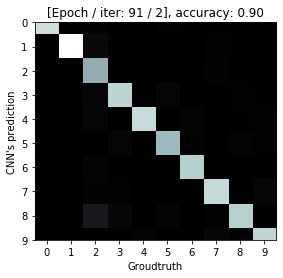

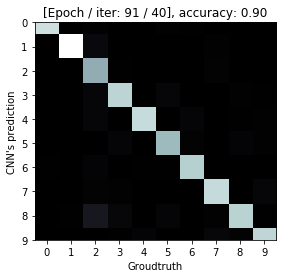

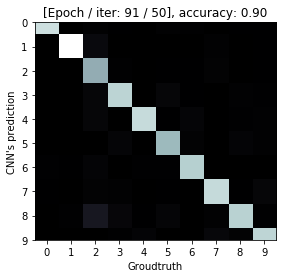

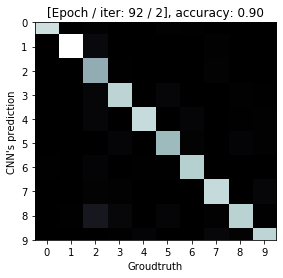

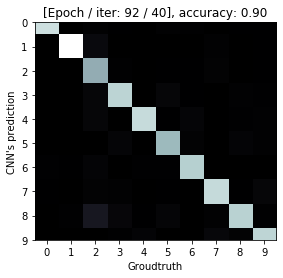

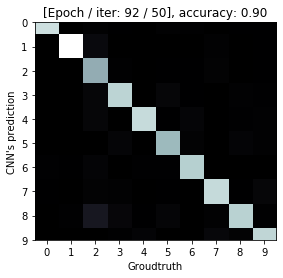

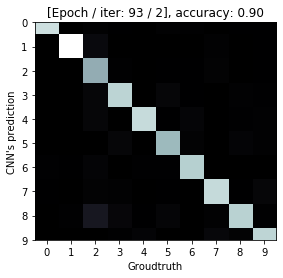

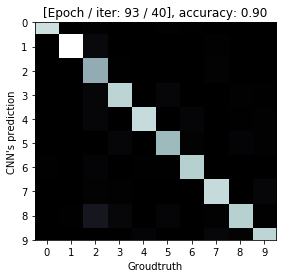

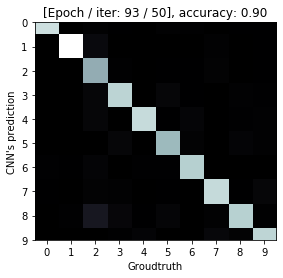

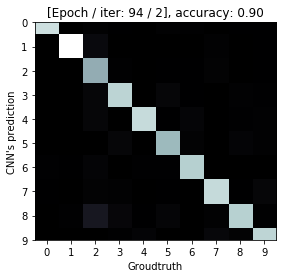

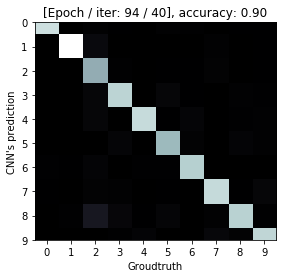

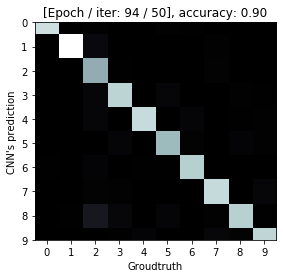

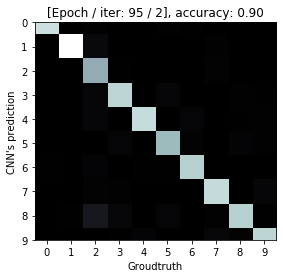

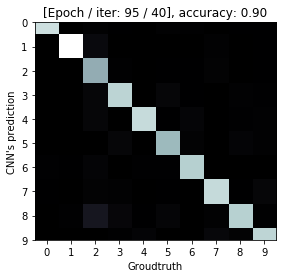

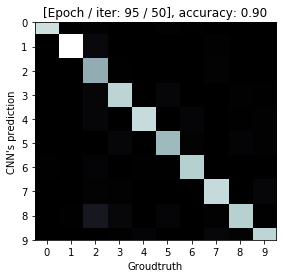

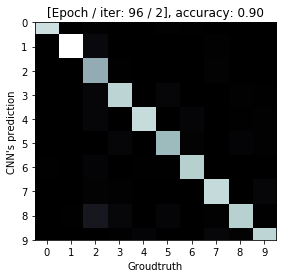

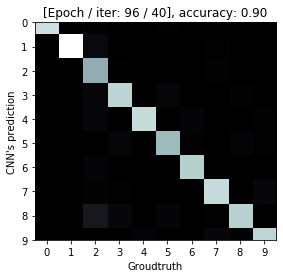

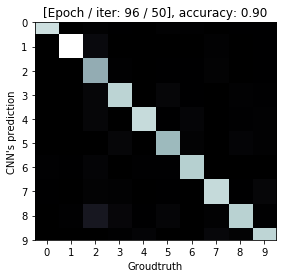

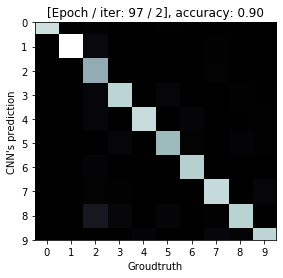

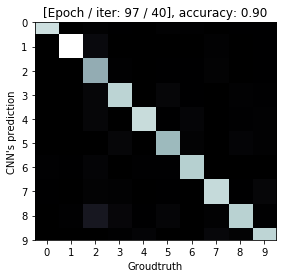

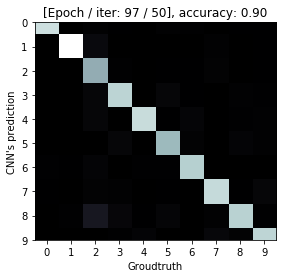

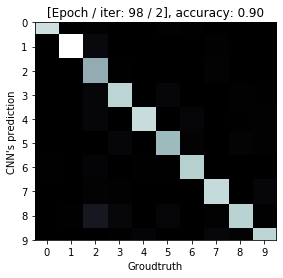

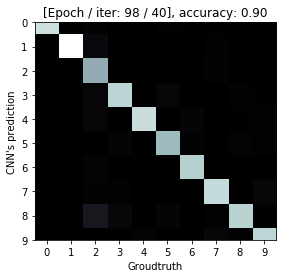

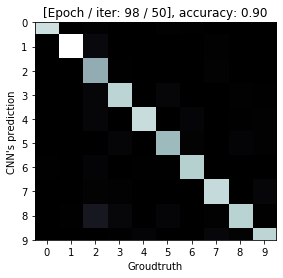

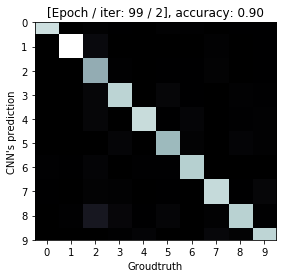

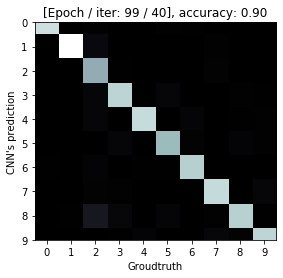

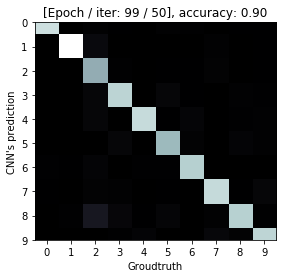

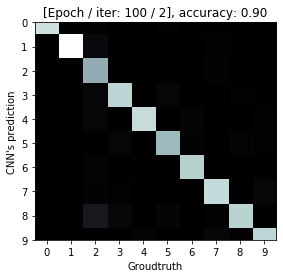

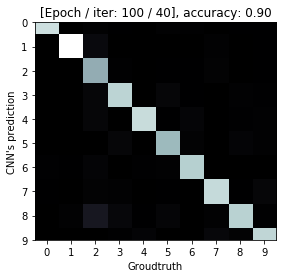

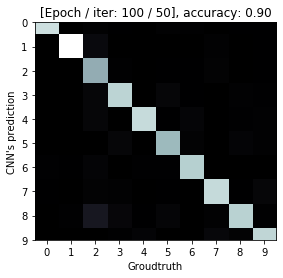

In [0]:
# Without mixup

import torchvision.transforms as transforms
import torch.utils as utils
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets as datasets


# Make a transform func.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Prepare dataloader
mnist_train = MyMNIST('./data', train=True,  download=True, transform=transform, use_mixup=False, limit_data_num=500)
trainloader = utils.data.DataLoader(mnist_train, batch_size=10, shuffle=True, num_workers=1)

mnist_test  = datasets.MNIST('./data', train=False, download=True, transform=transform)
testloader  = utils.data.DataLoader(mnist_test, batch_size=10, shuffle=False, num_workers=2)

# Make net
net = LeNet().cuda()
net.train()

# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
loss_func = nn.CrossEntropyLoss()
epoch_size  = 100
loss_rec    = []
iter_rec    = []
confmat_rec = []
global confmat_rec
for epoch in range(epoch_size):
    running_loss = 0.0
    ct_num       = 0.0
    # Iterate the dataloader
    for iteration, data in enumerate(trainloader):
        # Get one batch
        img, targets = data

        # Show the mixuped images.
        show_imgs = torchvision.utils.make_grid(img, nrow=10, normalize=True).numpy().transpose((1,2,0))
        plt.imshow(show_imgs)

        # Show the targets
        # print(targets)

        # Forward+backward, then update params.
        optimizer.zero_grad()
        preds, loss = train_step(img, targets, model=net, loss_func=loss_func)
        optimizer.step()

        # Logging
        with torch.no_grad():
            running_loss+= loss.item()
            ct_num+= 1
        if iteration in [1, 39, 59] or iteration%50 == 49:
            clear_output(wait=True)
            print("Epoch ["+str(epoch+1)+"/"+str(epoch_size)+"], Iteration: "+str(iteration+1)+", Loss: "+str(running_loss/ct_num)+'.')
            loss_rec.append(running_loss/ct_num)
            iter_rec.append(ct_num) 
            plt.clf()
            plt.grid(linestyle='-')
            plt.plot(loss_rec)
            plt.title("Training loss")
            plt.ylabel("Loss")
            plt.show()

        # Test the model
        if iteration in [1, 39, 59] or iteration%50 == 49:
            evaluate_model(net=net, testloader=testloader)
            # Record confusion matrix
            confmat_rec[-1]+= [epoch+1, iteration+1]

    # Lower the learning rate
    if epoch in [20, 60]:
        for param_group in optimizer.param_groups:
            param_group['lr']*= 0.1  

# Show all the confusion matrecs
for confmat_info in confmat_rec:
  accuracy, confmat, epoch, iteration = confmat_info
  plt.clf()
  plt.imshow(confmat, interpolation='nearest', cmap=plt.cm.bone)
  plt.yticks(np.arange(10))
  plt.xticks(np.arange(10))
  plt.ylabel("CNN's prediction")
  plt.xlabel("Groudtruth")
  plt.title("[Epoch / iter: "+str(epoch)+" / "+str(iteration)+"], accuracy: "+"%.2f"%accuracy)
  plt.show()
        